In [ ]:
# Fix randomness and hide warnings
seed = 42
%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rc('font', size=16)

2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%cp /gdrive/MyDrive/ANN-HOMEWORK2/training_dataset.zip /content/training_dataset.zip
#!unzip training_dataset.zip

# Load the data
training_data = np.load('training_data.npy')
valid_periods = np.load('valid_periods.npy')
categories = np.load('categories.npy')

In [ ]:
from Utils import split_dataset, build_sequences_optimized

dataset, labels = build_sequences_optimized(training_data, valid_periods)
train_validation_data, train_validation_labels, test_data, test_labels = split_dataset(dataset, labels)
train_data, train_labels, validation_data, validation_labels = split_dataset(train_validation_data, train_validation_labels)

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
train_labels = train_labels.reshape((train_labels.shape[0], train_labels.shape[1], 1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
test_labels = test_labels.reshape((test_labels.shape[0], test_labels.shape[1], 1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
test_labels = test_labels.reshape((test_labels.shape[0], test_labels.shape[1], 1))
train_data.shape

Dataset shape:  (48000, 200)
Train data shape:  (38400, 200)
Test data shape:  (9600, 200)
Train data shape:  (30720, 200)
Test data shape:  (7680, 200)


(30720, 200, 1)

In [ ]:
def augment_data(train_data, train_labels, num_rounds=2):
    num_augmentations=3
    total_size = num_rounds * num_augmentations * len(train_data)

    # Preallocate numpy arrays
    augmented_train_data = np.empty((total_size, *train_data.shape[1:]))
    augmented_train_labels = np.empty((total_size, *train_labels.shape[1:]))

    for round in range(num_rounds):
        print("Augmentation round: ", round)
        for i in range(len(train_data)):
            # Calculate the start index for this round and data point
            start_idx = round * num_augmentations * len(train_data) + i * num_augmentations

            # Add noise
            noise = np.random.normal(0, 0.05, train_data[i].shape)
            augmented_train_data[start_idx] = train_data[i] + noise
            augmented_train_labels[start_idx] = train_labels[i]

            # Add scaling
            scaling = np.random.uniform(0.8, 1.2)
            augmented_train_data[start_idx + 1] = train_data[i] * scaling
            augmented_train_labels[start_idx + 1] = train_labels[i] * scaling

            # Add constant value
            constant = np.random.uniform(-0.1, 0.1)
            augmented_train_data[start_idx + 2] = train_data[i] + constant
            augmented_train_labels[start_idx + 2] = train_labels[i] + constant

    return augmented_train_data, augmented_train_labels

augmented_train_data, augmented_train_labels = augment_data(train_data, train_labels)
# augmented_train_data, augmented_train_labels = augment_data(dataset, labels)
augmented_train_data = augmented_train_data.reshape((augmented_train_data.shape[0], augmented_train_data.shape[1], 1))
augmented_train_labels = augmented_train_labels.reshape((augmented_train_labels.shape[0], augmented_train_labels.shape[1], 1))

# del train_data, train_labels

Augmentation round:  0
Augmentation round:  1


In [ ]:
forecast_steps = 18

def residual_block(x, filters, kernel_size):
    """
    Define a basic residual block for Conv1D-based ResNet.
    """
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet1D_model(input_shape, output_shape):
    assert input_shape[0] >= output_shape[0], "Input time steps should be >= output time steps"

    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')

    x = Conv1D(64, 3, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Stack residual blocks
    num_blocks = 5 # Modify the number of residual blocks as needed
    for _ in range(num_blocks):
        x = residual_block(x, 64, 3)

    x = Conv1D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(forecast_steps, 3, padding='same')(x)  # Final Conv1D layer for forecasting
    x = Flatten()(x)
    output_layer = Dense(forecast_steps, activation='linear')(x)

    # Model instantiation
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='resnet1D_model')

    # Compiling the model
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    return model



Model: "resnet1D_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 200, 64)              256       ['input_layer[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 200, 64)              256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 200, 64)              0         ['batch_normaliza

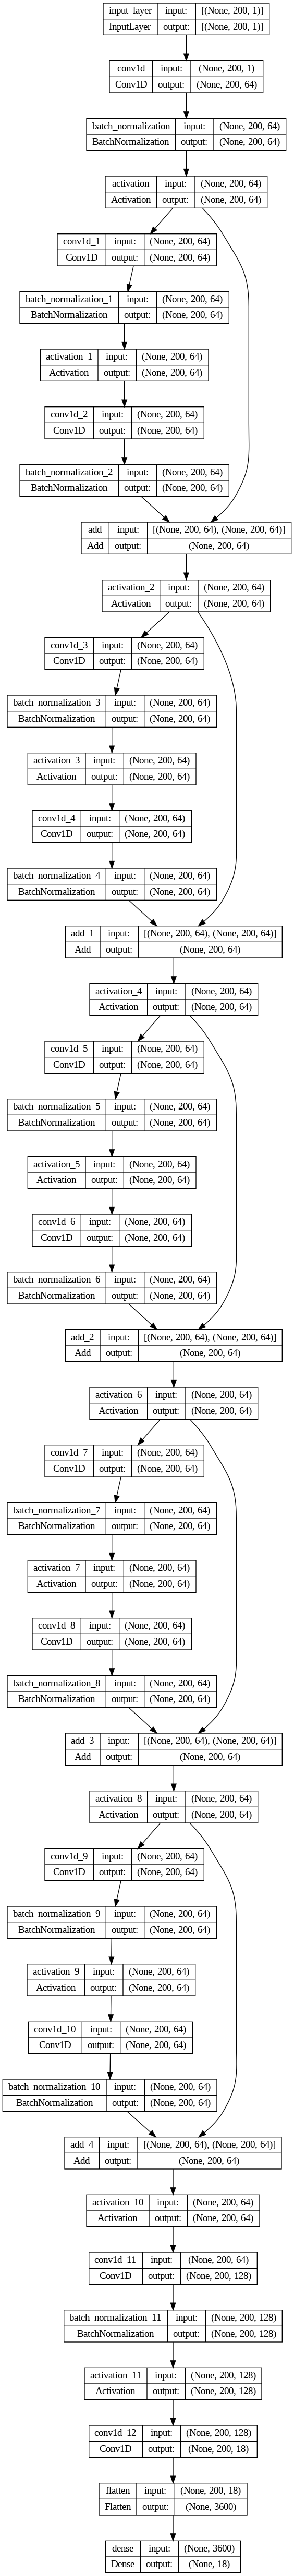

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Reshape, Flatten, Dense

input_shape = augmented_train_data.shape[1:]
output_shape = augmented_train_labels.shape[1:]
batch_size = 512
epochs = 50

model = build_resnet1D_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
print(batch_size)

512


In [ ]:
# Train the model
history = model.fit(
    x = augmented_train_data,
    y = augmented_train_labels,
    batch_size = batch_size,
    epochs = epochs,
     #validation_data=(validation_data, validation_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='loss', mode='min', min_delta=0.0003, patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)
    ]
    #cambiare val_loss al posto di loss
).history

Epoch 1/50
562/562 [==============================] - 66s 117ms/step - loss: 0.0252 - root_mean_squared_error: 0.1588 - lr: 0.0010
Epoch 2/50
562/562 [==============================] - 65s 116ms/step - loss: 0.0217 - root_mean_squared_error: 0.1472 - lr: 0.0010
Epoch 3/50
562/562 [==============================] - 65s 116ms/step - loss: 0.0205 - root_mean_squared_error: 0.1433 - lr: 0.0010
Epoch 4/50
562/562 [==============================] - 65s 116ms/step - loss: 0.0199 - root_mean_squared_error: 0.1411 - lr: 0.0010
Epoch 5/50
562/562 [==============================] - 65s 116ms/step - loss: 0.0192 - root_mean_squared_error: 0.1387 - lr: 0.0010
Epoch 6/50
562/562 [==============================] - 65s 116ms/step - loss: 0.0187 - root_mean_squared_error: 0.1369 - lr: 0.0010
Epoch 7/50
562/562 [==============================] - 65s 116ms/step - loss: 0.0183 - root_mean_squared_error: 0.1353 - lr: 0.0010
Epoch 8/50
562/562 [==============================] - 65s 116ms/step - loss: 0.0179

In [ ]:
model.save("resnet1D_5_alldata_model.h5")

In [ ]:
from Utils import evaluate_model

test_data_predictions = model.predict(test_data)
evaluate_model(test_data_predictions, test_labels)

2/2 [==============================] - 0s 13ms/step
MAE: 0.08583662202760145
MSE: 0.01434428607111157
RMSE: 0.11976763365413699


In [ ]:
# Evaluate random samples
evaluate_model(np.random.rand(*test_data_predictions.shape), test_labels)

MAE: 0.3136521570798323
MSE: 0.14659363495679692
RMSE: 0.38287548231350216


In [ ]:
from Utils import plot_predictions
for _ in range(10):
    idx = np.random.randint(0, len(test_data))
    plot_predictions(test_data, test_data_predictions, test_labels,idx)
    # Utils.plot_predictions(train_data, test_data_predictions, train_labels,idx)

# with attention


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Flatten, Dense, Multiply, Permute, Lambda

forecast_steps = 18

# Define the attention mechanism
def self_attention(x):
    # Compute attention weights
    attention_weights = Dense(units=1, activation='softmax')(x)
    # Apply attention weights to the input
    attention_output = Multiply()([x, attention_weights])
    return attention_output

def residual_block_with_attention(x, filters, kernel_size):
    """
    Define a residual block with attention for Conv1D-based ResNet.
    """
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Introduce attention mechanism
    attention = self_attention(x)

    x = Add()([attention, shortcut])
    x = Activation('relu')(x)
    return x

# Modify the existing ResNet model to include attention mechanism
def build_resnet1D_model_with_attention(input_shape, output_shape):
    assert input_shape[0] >= output_shape[0], "Input time steps should be >= output time steps"

    # Input layer
    input_layer = Input(shape=input_shape, name='input_layer')

    x = Conv1D(64, 3, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Stack residual blocks with attention
    num_blocks = 5
    for _ in range(num_blocks):
        x = residual_block_with_attention(x, 64, 3)

    x = Conv1D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(forecast_steps, 3, padding='same')(x)  # Final Conv1D layer for forecasting
    x = Flatten()(x)
    output_layer = Dense(forecast_steps, activation='linear')(x)

    # Model instantiation
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='resnet1D_model_with_attention')

    # Compiling the model
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    return model


input_shape = augmented_train_data.shape[1:]
output_shape = augmented_train_labels.shape[1:]
batch_size = 512
epochs = 20


# Rebuild the model with attention
model_with_attention = build_resnet1D_model_with_attention(input_shape, output_shape)
model_with_attention.summary()
tf.keras.utils.plot_model(model_with_attention, expand_nested=True, show_shapes=True)

# Train the model with attention
history_attention = model_with_attention.fit(
    x=augmented_train_data,
    y=augmented_train_labels,
    validation_data=(validation_data, validation_labels),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0003, patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)
    ]
)

Model: "resnet1D_model_with_attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d_25 (Conv1D)          (None, 200, 64)              256       ['input_layer[0][0]']         
                                                                                                  
 batch_normalization_24 (Ba  (None, 200, 64)              256       ['conv1d_25[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_24 (Activation)  (None, 200, 64)              0         ['

In [ ]:
from Utils import evaluate_model

test_data_predictions = model_with_attention.predict(test_data)
evaluate_model(test_data_predictions, test_labels)

300/300 [==============================] - 2s 4ms/step
MAE: 0.11753946789922073
MSE: 0.027268967707561657
RMSE: 0.16513318172784552


In [ ]:
model_with_attention.save("resnet1D_attention_model.h5")